In [158]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy.stats import norm
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.losses import mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, models
from scipy.stats import norm

from tensorflow.keras.layers import Input, Dense,Dropout

In [159]:
df = pd.read_csv("traj_1.out", header=None, sep='\s+')
df.shape

(6666, 5)

In [160]:
df = df.drop(df.columns[[0]], axis=1)
df.head()

,1,2,3,4
0,0.352275,0.133927,-0.184188,0.179414
1,0.218618,-0.321963,0.051179,0.087885
2,-0.305430,-0.217584,0.080156,-0.070234
3,-0.232447,0.255190,-0.171774,-0.181999
4,0.208963,0.265229,-0.163701,0.192774


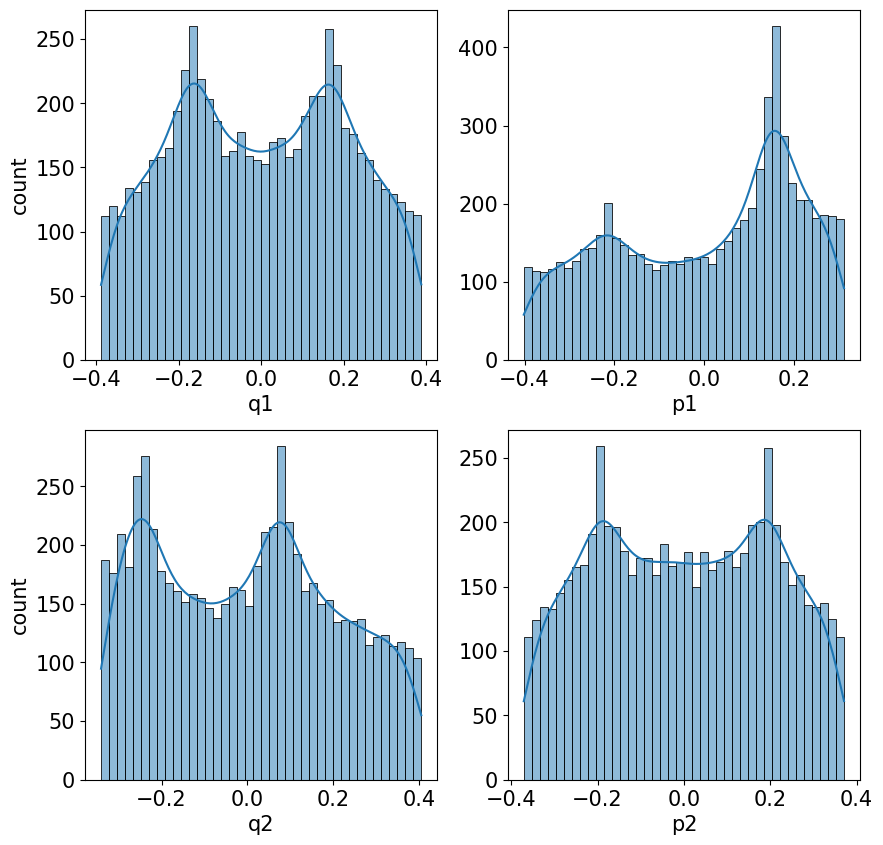

In [161]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
titles = [["q1", "p1"], ["q2", "p2"]]

# Frequency distribution
for i in range(2):
    for j in range(2):
        p = sns.histplot(df[df.columns[i*2+j]], ax = ax[i][j], kde = True, fill = True, bins = 40)
        #plt.hist(df1[:,1], bins=20) 
        p.set_xlabel(titles[i][j], fontsize=15)
        if j == 0:
            p.set_ylabel('count',fontsize=15)
        elif j == 1:
            p.set_ylabel('')
        p.tick_params(axis='x', which='major', labelsize=15)
        p.tick_params(axis='y', which='major', labelsize=15)

        

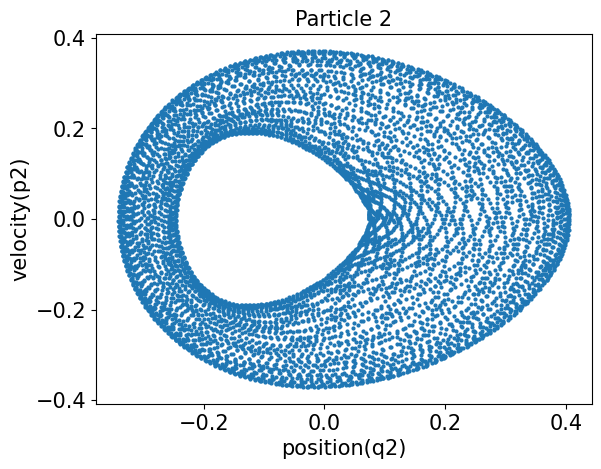

In [162]:
plt.scatter(x = df.iloc[:,2], y = df.iloc[:,3], s = 4, cmap='winter')
plt.xlabel("position(q2)",  fontsize=15)
plt.ylabel("velocity(p2)",  fontsize=15)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.title('Particle 2', fontsize = 15)
plt.show()

In [163]:
df.shape

(6666, 4)

In [164]:
# change dataframe to numpy_array
data = df.to_numpy()               # q1, p1, q2, p2

# create an instance of MinMaxScaler
scaler = MinMaxScaler()

# fit and transform the data using MinMaxScaler
scaled_data = scaler.fit_transform(data)
scaled_data

array([[0.95408582, 0.75201544, 0.21033574, 0.74186588],
       [0.7818931 , 0.11189686, 0.52524734, 0.61845959],
       [0.10675419, 0.25845572, 0.56401764, 0.40526927],
       ...,
       [0.43356417, 0.8695833 , 0.37558393, 0.04665301],
       [0.82102846, 0.77915836, 0.04994121, 0.61763948],
       [0.86512577, 0.33109849, 0.49095803, 0.81367702]])

In [165]:
encoding_dim = 32
latent_dim = 2
beta = 0.5                        # weight of the kl loss
original_dim = 4 

inputs = keras.Input(shape=(original_dim,))
x = layers.Dense(encoding_dim, activation='relu')(inputs)# sparcity here
x = layers.Dropout(0.5)(x)
x = layers.Dense(encoding_dim/2, activation='relu')(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(encoding_dim/4, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
encoder = tf.keras.Model(inputs, [z_mean, z_log_var], name='encoder')

print("Shape of z_mean:", z_mean.shape)  # (None, 2)  and None shows the batch size
print("Shape of z_log_var:", z_log_var.shape)

latent_inputs = keras.Input(shape=(latent_dim,))
#x = layers.Dense(encoding_dim/4, activation='relu')(latent_inputs)
x = layers.Dense(encoding_dim/2, activation='relu')(latent_inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(encoding_dim, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(original_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

Shape of z_mean: (None, 2)
Shape of z_log_var: (None, 2)


In [166]:
from keras import backend as K



# define the VAE custom model
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, encoder,decoder):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        #self.encoding_dim = 32
        self.encoder = encoder
        self.decoder = decoder
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def sample_z(self, z_mean, z_log_var):  # applies the reparamterization trick
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var = self.encoder(data)
            z = self.sample_z(z_mean, z_log_var)
            reconstructed = self.decoder(z)

            # compute losses
            reconstruction_loss = keras.losses.mean_squared_error(data , reconstructed) # or mse(data , reconstructed)
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=1)
            kl_loss *= -0.5 
            total_loss = K.mean(reconstruction_loss + beta * kl_loss)

        # compute gradients and update weights
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [167]:
X_train, X_test = train_test_split(scaled_data, test_size=0.25, random_state=42)
print("X_train = ", X_train.shape, '\n' , 'X_test =', X_test.shape)

X_train =  (4999, 4) 
 X_test = (1667, 4)


In [168]:
from keras.callbacks import EarlyStopping


vae = VAE(latent_dim, encoder, decoder)
your_optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
vae.compile(optimizer = your_optimizer,  metrics=['accuracy'])
#es = EarlyStopping(monitor='kl_loss', patience=4)
es = EarlyStopping(monitor='loss', min_delta=0, patience=4, verbose=5, mode='auto')
history = vae.fit(X_train, callbacks=[es], epochs = 100, batch_size =128, verbose=1 )  #  validation_data=(X_test, )

Epoch 1/100
40/40 [==============================] - 1s 2ms/step - loss: 0.4894 - reconstruction_loss: 0.4688 - kl_loss: 0.0148
Epoch 2/100
40/40 [==============================] - 0s 2ms/step - loss: 0.4333 - reconstruction_loss: 0.4156 - kl_loss: 0.0124
Epoch 3/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3909 - reconstruction_loss: 0.3746 - kl_loss: 0.0127
Epoch 4/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3539 - reconstruction_loss: 0.3424 - kl_loss: 0.0127
Epoch 5/100
40/40 [==============================] - 0s 2ms/step - loss: 0.3264 - reconstruction_loss: 0.3114 - kl_loss: 0.0116
Epoch 6/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2976 - reconstruction_loss: 0.2845 - kl_loss: 0.0100
Epoch 7/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2683 - reconstruction_loss: 0.2577 - kl_loss: 0.0087
Epoch 8/100
40/40 [==============================] - 0s 2ms/step - loss: 0.2447 - reconstruction_loss: 0

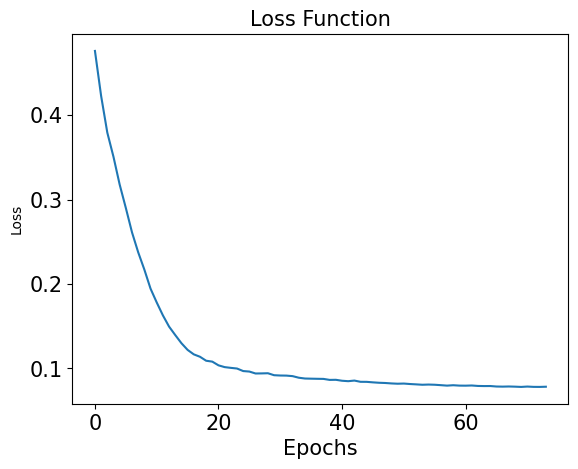

In [170]:
plt.plot(history.history['loss'])
plt.title('Loss Function', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss') #, fontsize= 15)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()

In [16]:
X_test.shape

(1667, 4)

# plot latent space 

53/53 [==============================] - 0s 927us/step
[[-4.7026053e-03 -6.1345892e-04]
 [ 5.1061064e-03  7.9147331e-03]
 [-4.5450125e-03 -4.6679345e-03]
 ...
 [ 4.8488379e-05 -1.9496572e-03]
 [ 3.4309924e-04 -1.3164771e-03]
 [ 1.8939525e-03 -5.5730869e-03]]


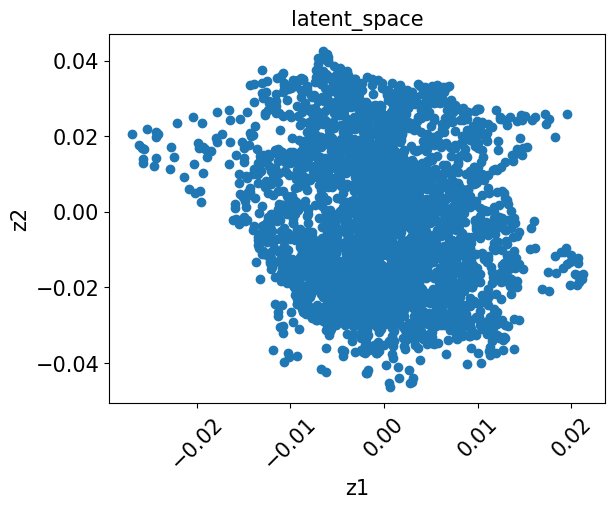

In [171]:
x_test_encoded = vae.encoder.predict(X_test)
epsioln = np.random.normal(size=len(x_test_encoded[0]))
print(x_test_encoded[0])
combine1 = x_test_encoded[0] + x_test_encoded[1] #* epsioln
#z = combine1
#plt.scatter(z[:,0], z[:,1])  # (z1, z2)
plt.scatter(x_test_encoded[0], x_test_encoded[1])

plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.title('latent_space', fontsize = 15)
plt.xlabel('z1', fontsize = 15)
plt.ylabel('z2', fontsize= 15)
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()

[[-0.00382166  0.00358637]
 [ 0.01637471 -0.00159258]
 [-0.00251438  0.02251076]
 ...
 [-0.01545478 -0.00266374]
 [ 0.01449389  0.00189715]
 [ 0.00666808  0.01793665]]


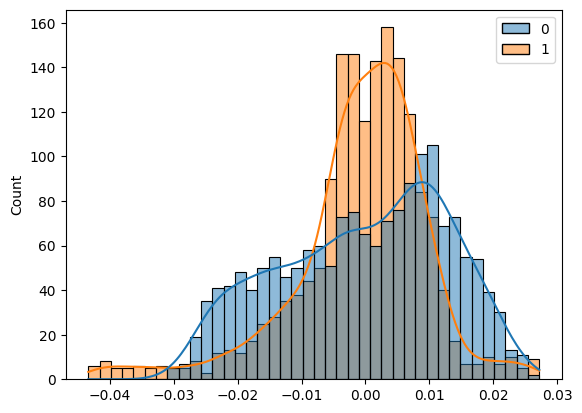

In [151]:
sns.histplot(x_test_encoded[0], kde = True, fill = True, bins = 40)
print(x_test_encoded[0])
plt.show()

In [51]:
# to check 
enc_data = vae.encoder.predict(X_test)
enc_data_data = np.array(enc_data)
print(enc_data_data.shape)

53/53 [==============================] - 0s 957us/step
(2, 1667, 2)


In [52]:
print(enc_data_data)

[[[-1.9103466e-02 -1.5539793e-02]
  [-4.5445655e-03 -1.4150878e-02]
  [ 1.4912561e-03 -6.4782239e-03]
  ...
  [ 9.7183827e-03  7.6012034e-03]
  [-2.7406272e-03  1.1819119e-02]
  [ 5.9856595e-03 -4.5178737e-03]]

 [[-4.5804260e-03  7.2318912e-03]
  [ 4.2332463e-02  1.7541502e-02]
  [ 1.4320540e-02 -9.2864335e-03]
  ...
  [ 3.6792114e-02 -4.3945611e-03]
  [ 6.5212389e-03  8.0451369e-05]
  [ 7.2924448e-03 -1.8537439e-02]]]


In [53]:
enc_data = vae.encoder.predict(X_test)
z = vae.sample_z(enc_data[0], enc_data[1])
gen_data = vae.decoder.predict(z)
print(tf.reduce_mean((keras.losses.mean_squared_error(X_test, gen_data))))

53/53 [==============================] - 0s 776us/step
tf.Tensor(0.07775183, shape=(), dtype=float32)


# evaluate and generate new data

In [172]:
import itertools as it

In [173]:
import itertools as it
grid_x = np.arange(-1, 1, 0.03)
z_smaple = np.array(list(it.product(grid_x, grid_x)))

In [174]:
gen_data = vae.decoder.predict(z_smaple)

new_data = scaler.inverse_transform(gen_data)

141/141 [==============================] - 0s 832us/step


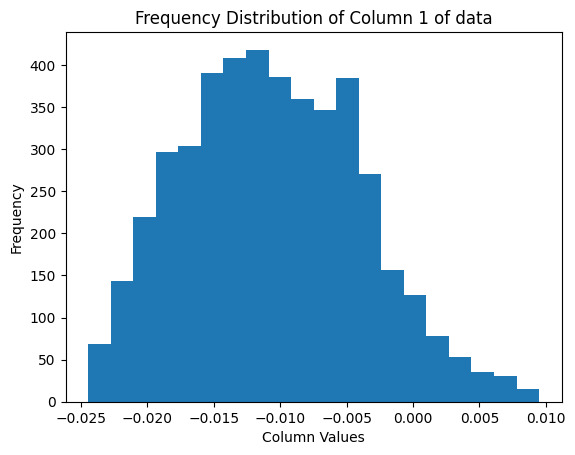

In [175]:
new_data = scaler.inverse_transform(gen_data)
plt.hist(new_data[:,1], bins=20)  
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Column 1 of data')
plt.show()

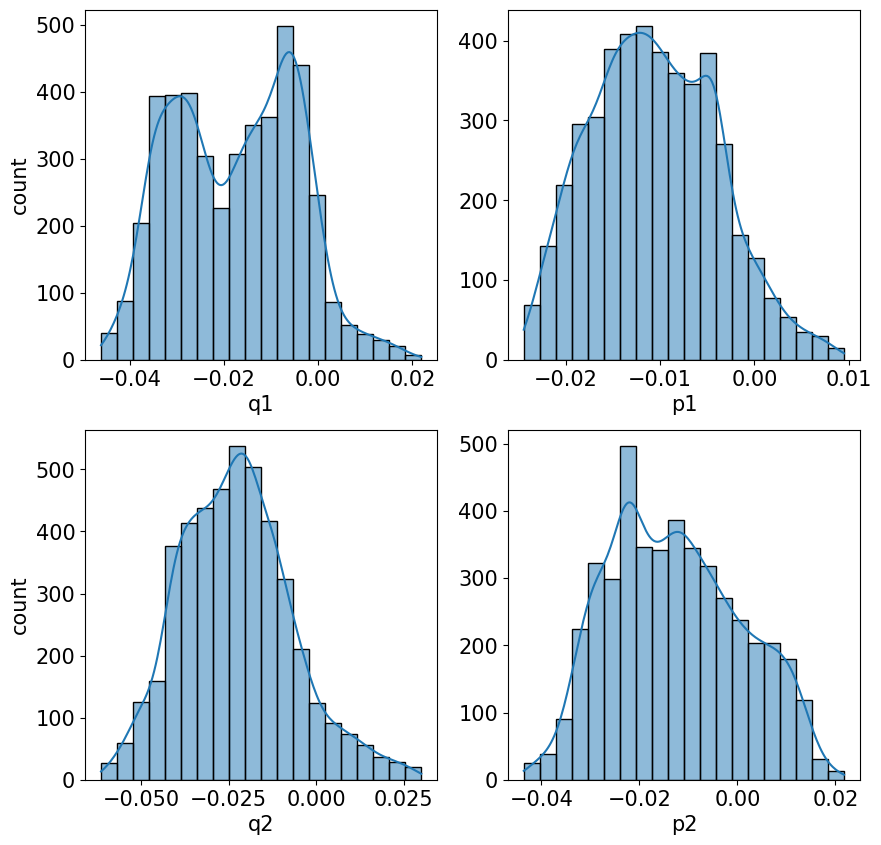

In [176]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
titles = [["q1", "p1"], ["q2", "p2"]]

# Frequency distribution
for i in range(2):
    for j in range(2):
        p = sns.histplot(new_data[:,i*2+j], ax = ax[i][j], kde = True, fill = True, bins = 20)
        #plt.hist(df1[:,1], bins=20) 
        p.set_xlabel(titles[i][j], fontsize=15)
        if j == 0:
            p.set_ylabel('count',fontsize=15)
        elif j == 1:
            p.set_ylabel('')
        p.tick_params(axis='x', which='major', labelsize=15)
        p.tick_params(axis='y', which='major', labelsize=15)

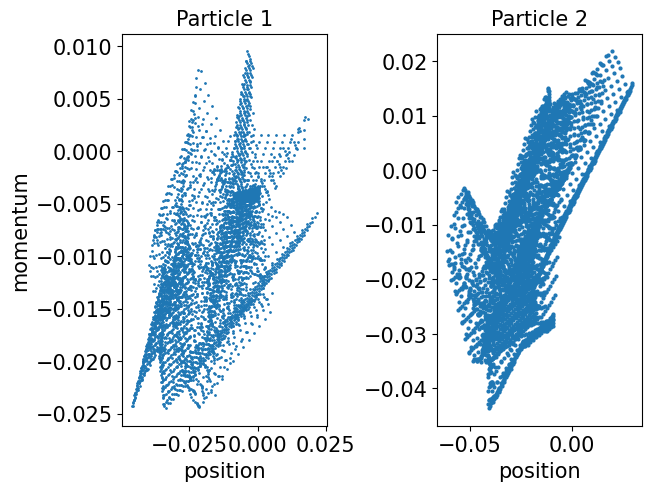

In [177]:
fig, axs = plt.subplots(1, 2, layout='constrained')

ax = axs[0]
ax.scatter(x = new_data[:,0], y = new_data[:,1], s = 1, cmap='winter')
ax.set_xlabel('position', fontsize = 15)
ax.set_ylabel('momentum', fontsize = 15)
ax.set_title('Particle 1', fontsize = 15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y',  labelsize=15)

ax = axs[1]
ax.scatter(x = new_data[:,2], y = new_data[:,3], s = 4, cmap='winter')
ax.set_xlabel("position", fontsize = 15)
#ax.set_ylabel("velocity")
ax.set_title('Particle 2', fontsize = 15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y',  labelsize=15)

plt.show()